In [16]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report
from torchsummary import summary

In [17]:
class IVFDataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        # print(y, len(y))
        
        if y is None:
            self.y = y
        else:
            self.y = torch.LongTensor(y)
        self.x = torch.FloatTensor(x)
        
    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [18]:
class DNN_Regression(nn.Module):
    def __init__(self, input_dim):
        super(DNN_Regression, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 7)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [19]:
model = DNN_Regression(22)
print(model)

DNN_Regression(
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=7, bias=True)
  )
)


In [20]:
summary(model, (1, 22))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]             368
              ReLU-2                [-1, 1, 16]               0
            Linear-3                 [-1, 1, 8]             136
              ReLU-4                 [-1, 1, 8]               0
            Linear-5                 [-1, 1, 7]              63
Total params: 567
Trainable params: 567
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [34]:
train_loss=[] 
val_loss=[]

def trainer(train_loader, valid_loader, model, config, device):
    
    # TODO try differnet criterion or optimizer 
    # criterion = nn.MSELoss(reduction='mean')
    # w=torch.tensor([0.1,0.9])
    # criterion = nn.CrossEntropyLoss(weight=w)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], betas=(0.9, 0.999), eps=1e-08)
    writer = SummaryWriter()
    
    if not os.path.isdir('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models'):
        os.mkdir('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models') # Create directory of saving models.
    
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    
    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)
        train_acc = []
        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            
            loss = criterion(pred, y)
            
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            
            acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()
            train_acc.append(acc)
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
        
        print(f"Train Acc: {sum(train_acc) / len(train_acc)}")
        mean_train_loss = sum(loss_record)/len(loss_record)
        train_loss.append(mean_train_loss)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        val_acc = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
                
                acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()
                val_acc.append(acc)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        val_loss.append(mean_valid_loss)
        print(f"Val Acc: {sum(val_acc) / len(val_acc)}")
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [22]:
device = 'cpu'

config = {
    'seed': 1322,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-4,              
    'early_stop': 20,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': '/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models/model_pregnancy_classification_Adam_WC.ckpt'  # Your model will be saved here.
}

In [23]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [24]:
same_seed(config['seed'])

In [25]:
train_x = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/train_pregnancy_binary_x.csv')
train_y = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/train_pregnancy_binary_y.csv')
test_x = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/test_pregnancy_binary_x.csv')
test_y = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/test_pregnancy_binary_y.csv')

In [26]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.10, random_state=42)

In [27]:
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(112338, 20) (112338, 1)
(12482, 20) (12482, 1)
(31205, 20) (31205, 1)


In [28]:
train_y

,Total number of IVF pregnancies
123971,0
33543,0
29687,0
29787,0
123053,0
...,...
119879,1
103694,0
860,0
15795,1


In [29]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy().ravel()
valid_x = valid_x.to_numpy()
valid_y = valid_y.to_numpy().ravel()
test_x  = test_x.to_numpy()
test_y = test_y.to_numpy().ravel()

In [30]:
train_dataset = IVFDataset(train_x, train_y)
valid_dataset = IVFDataset(valid_x, valid_y)
test_dataset = IVFDataset(test_x)

In [31]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

In [32]:
train_loss = []
val_loss = []
model = DNN_Regression(input_dim=train_x.shape[1]).to(device)

In [35]:
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 221.24it/s, loss=1.11]


Train Acc: 0.5682580471038818
Val Acc: 0.8417578935623169
Epoch [1/500]: Train loss: 1.4617, Valid loss: 1.0594
Saving model with loss 1.059...


Epoch [2/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:02<00:00, 202.98it/s, loss=0.706]


Train Acc: 0.8408889174461365
Val Acc: 0.841655969619751
Epoch [2/500]: Train loss: 0.8268, Valid loss: 0.6384
Saving model with loss 0.638...


Epoch [3/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.40it/s, loss=0.471]


Train Acc: 0.840914249420166
Val Acc: 0.8420125842094421
Epoch [3/500]: Train loss: 0.5705, Valid loss: 0.5269
Saving model with loss 0.527...


Epoch [4/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 236.11it/s, loss=0.506]


Train Acc: 0.8409005999565125
Val Acc: 0.8411234021186829
Epoch [4/500]: Train loss: 0.5146, Valid loss: 0.4963
Saving model with loss 0.496...


Epoch [5/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:02<00:00, 216.84it/s, loss=0.502]


Train Acc: 0.8405330181121826
Val Acc: 0.8411298990249634
Epoch [5/500]: Train loss: 0.4900, Valid loss: 0.4767
Saving model with loss 0.477...


Epoch [6/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 239.26it/s, loss=0.52]


Train Acc: 0.8402779698371887
Val Acc: 0.8413082957267761
Epoch [6/500]: Train loss: 0.4736, Valid loss: 0.4636
Saving model with loss 0.464...


Epoch [7/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:02<00:00, 207.13it/s, loss=0.408]


Train Acc: 0.8392127752304077
Val Acc: 0.8399308919906616
Epoch [7/500]: Train loss: 0.4631, Valid loss: 0.4553
Saving model with loss 0.455...


Epoch [8/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 228.51it/s, loss=0.45]


Train Acc: 0.8383785486221313
Val Acc: 0.8398798704147339
Epoch [8/500]: Train loss: 0.4564, Valid loss: 0.4494
Saving model with loss 0.449...


Epoch [9/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 225.26it/s, loss=0.389]


Train Acc: 0.8381914496421814
Val Acc: 0.8396341800689697
Epoch [9/500]: Train loss: 0.4514, Valid loss: 0.4448
Saving model with loss 0.445...


Epoch [10/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 224.64it/s, loss=0.379]


Train Acc: 0.8382834792137146
Val Acc: 0.8389010429382324
Epoch [10/500]: Train loss: 0.4474, Valid loss: 0.4414
Saving model with loss 0.441...


Epoch [11/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 219.30it/s, loss=0.413]


Train Acc: 0.838171660900116
Val Acc: 0.8383364677429199
Epoch [11/500]: Train loss: 0.4435, Valid loss: 0.4374
Saving model with loss 0.437...


Epoch [12/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.17it/s, loss=0.427]


Train Acc: 0.8384397625923157
Val Acc: 0.8384194374084473
Epoch [12/500]: Train loss: 0.4396, Valid loss: 0.4335
Saving model with loss 0.433...


Epoch [13/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 205.34it/s, loss=0.438]


Train Acc: 0.8382628560066223
Val Acc: 0.8386808037757874
Epoch [13/500]: Train loss: 0.4350, Valid loss: 0.4288
Saving model with loss 0.429...


Epoch [14/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 216.95it/s, loss=0.357]


Train Acc: 0.8383476734161377
Val Acc: 0.8385534286499023
Epoch [14/500]: Train loss: 0.4309, Valid loss: 0.4258
Saving model with loss 0.426...


Epoch [15/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 209.22it/s, loss=0.395]


Train Acc: 0.838229238986969
Val Acc: 0.8387318253517151
Epoch [15/500]: Train loss: 0.4269, Valid loss: 0.4209
Saving model with loss 0.421...


Epoch [16/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 232.06it/s, loss=0.432]


Train Acc: 0.8380721211433411
Val Acc: 0.8384959101676941
Epoch [16/500]: Train loss: 0.4227, Valid loss: 0.4175
Saving model with loss 0.417...


Epoch [17/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 215.76it/s, loss=0.445]


Train Acc: 0.8381185531616211
Val Acc: 0.8391304016113281
Epoch [17/500]: Train loss: 0.4187, Valid loss: 0.4137
Saving model with loss 0.414...


Epoch [18/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.73it/s, loss=0.384]


Train Acc: 0.8385011553764343
Val Acc: 0.8391147255897522
Epoch [18/500]: Train loss: 0.4145, Valid loss: 0.4096
Saving model with loss 0.410...


Epoch [19/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 232.63it/s, loss=0.426]


Train Acc: 0.8384775519371033
Val Acc: 0.8392964005470276
Epoch [19/500]: Train loss: 0.4105, Valid loss: 0.4058
Saving model with loss 0.406...


Epoch [20/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.64it/s, loss=0.354]


Train Acc: 0.838740348815918
Val Acc: 0.8394812941551208
Epoch [20/500]: Train loss: 0.4066, Valid loss: 0.4020
Saving model with loss 0.402...


Epoch [21/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 241.35it/s, loss=0.426]


Train Acc: 0.8386059999465942
Val Acc: 0.840004026889801
Epoch [21/500]: Train loss: 0.4028, Valid loss: 0.3980
Saving model with loss 0.398...


Epoch [22/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.44it/s, loss=0.401]


Train Acc: 0.8391871452331543
Val Acc: 0.8404568433761597
Epoch [22/500]: Train loss: 0.3991, Valid loss: 0.3945
Saving model with loss 0.395...


Epoch [23/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 261.45it/s, loss=0.387]


Train Acc: 0.8390300869941711
Val Acc: 0.8409959673881531
Epoch [23/500]: Train loss: 0.3957, Valid loss: 0.3916
Saving model with loss 0.392...


Epoch [24/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 232.96it/s, loss=0.443]


Train Acc: 0.839747965335846
Val Acc: 0.8408620357513428
Epoch [24/500]: Train loss: 0.3927, Valid loss: 0.3893
Saving model with loss 0.389...


Epoch [25/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 230.41it/s, loss=0.427]


Train Acc: 0.8399615287780762
Val Acc: 0.8405718803405762
Epoch [25/500]: Train loss: 0.3900, Valid loss: 0.3866
Saving model with loss 0.387...


Epoch [26/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 221.76it/s, loss=0.398]


Train Acc: 0.8403094410896301
Val Acc: 0.8411044478416443
Epoch [26/500]: Train loss: 0.3877, Valid loss: 0.3847
Saving model with loss 0.385...


Epoch [27/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 253.43it/s, loss=0.397]


Train Acc: 0.8407067656517029
Val Acc: 0.8404346108436584
Epoch [27/500]: Train loss: 0.3856, Valid loss: 0.3830
Saving model with loss 0.383...


Epoch [28/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 209.51it/s, loss=0.378]


Train Acc: 0.8408421874046326
Val Acc: 0.841547429561615
Epoch [28/500]: Train loss: 0.3837, Valid loss: 0.3810
Saving model with loss 0.381...


Epoch [29/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 220.30it/s, loss=0.383]


Train Acc: 0.841140866279602
Val Acc: 0.8419460654258728
Epoch [29/500]: Train loss: 0.3821, Valid loss: 0.3794
Saving model with loss 0.379...


Epoch [30/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 212.06it/s, loss=0.329]


Train Acc: 0.8412821292877197
Val Acc: 0.8419173359870911
Epoch [30/500]: Train loss: 0.3806, Valid loss: 0.3784
Saving model with loss 0.378...


Epoch [31/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 225.91it/s, loss=0.338]


Train Acc: 0.841629147529602
Val Acc: 0.8419173359870911
Epoch [31/500]: Train loss: 0.3793, Valid loss: 0.3773
Saving model with loss 0.377...


Epoch [32/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.91it/s, loss=0.318]


Train Acc: 0.8416764140129089
Val Acc: 0.8419525623321533
Epoch [32/500]: Train loss: 0.3780, Valid loss: 0.3763
Saving model with loss 0.376...


Epoch [33/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 252.59it/s, loss=0.375]


Train Acc: 0.8415521383285522
Val Acc: 0.8423956036567688
Epoch [33/500]: Train loss: 0.3770, Valid loss: 0.3750
Saving model with loss 0.375...


Epoch [34/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 226.98it/s, loss=0.339]


Train Acc: 0.8420156240463257
Val Acc: 0.8422459959983826
Epoch [34/500]: Train loss: 0.3759, Valid loss: 0.3743
Saving model with loss 0.374...


Epoch [35/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 244.81it/s, loss=0.378]


Train Acc: 0.8418824672698975
Val Acc: 0.8420323133468628
Epoch [35/500]: Train loss: 0.3749, Valid loss: 0.3737
Saving model with loss 0.374...


Epoch [36/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.01it/s, loss=0.338]


Train Acc: 0.8419830799102783
Val Acc: 0.8428550362586975
Epoch [36/500]: Train loss: 0.3741, Valid loss: 0.3728
Saving model with loss 0.373...


Epoch [37/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 238.74it/s, loss=0.317]


Train Acc: 0.8420729041099548
Val Acc: 0.842191755771637
Epoch [37/500]: Train loss: 0.3732, Valid loss: 0.3723
Saving model with loss 0.372...


Epoch [38/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 256.49it/s, loss=0.316]


Train Acc: 0.8424891829490662
Val Acc: 0.8427975177764893
Epoch [38/500]: Train loss: 0.3725, Valid loss: 0.3713
Saving model with loss 0.371...


Epoch [39/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.69it/s, loss=0.403]


Train Acc: 0.8427377343177795
Val Acc: 0.842775285243988
Epoch [39/500]: Train loss: 0.3718, Valid loss: 0.3708
Saving model with loss 0.371...


Epoch [40/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 228.11it/s, loss=0.391]


Train Acc: 0.8426554799079895
Val Acc: 0.8427210450172424
Epoch [40/500]: Train loss: 0.3713, Valid loss: 0.3701
Saving model with loss 0.370...


Epoch [41/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.01it/s, loss=0.39]


Train Acc: 0.8423076272010803
Val Acc: 0.8432469964027405
Epoch [41/500]: Train loss: 0.3706, Valid loss: 0.3696
Saving model with loss 0.370...


Epoch [42/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 256.71it/s, loss=0.401]


Train Acc: 0.8425775170326233
Val Acc: 0.8432215452194214
Epoch [42/500]: Train loss: 0.3702, Valid loss: 0.3694
Saving model with loss 0.369...


Epoch [43/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 233.73it/s, loss=0.399]


Train Acc: 0.8428286910057068
Val Acc: 0.8433489203453064
Epoch [43/500]: Train loss: 0.3698, Valid loss: 0.3686
Saving model with loss 0.369...


Epoch [44/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.74it/s, loss=0.314]


Train Acc: 0.8426604866981506
Val Acc: 0.8429314494132996
Epoch [44/500]: Train loss: 0.3692, Valid loss: 0.3685
Saving model with loss 0.368...


Epoch [45/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.80it/s, loss=0.415]


Train Acc: 0.8426517844200134
Val Acc: 0.8431771993637085
Epoch [45/500]: Train loss: 0.3690, Valid loss: 0.3682
Saving model with loss 0.368...


Epoch [46/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 260.15it/s, loss=0.405]


Train Acc: 0.8427486419677734
Val Acc: 0.8426799178123474
Epoch [46/500]: Train loss: 0.3687, Valid loss: 0.3688


Epoch [47/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 233.89it/s, loss=0.328]


Train Acc: 0.8426682353019714
Val Acc: 0.8433908820152283
Epoch [47/500]: Train loss: 0.3683, Valid loss: 0.3679
Saving model with loss 0.368...


Epoch [48/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 230.50it/s, loss=0.322]


Train Acc: 0.8426307439804077
Val Acc: 0.8431706428527832
Epoch [48/500]: Train loss: 0.3681, Valid loss: 0.3673
Saving model with loss 0.367...


Epoch [49/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 226.23it/s, loss=0.436]


Train Acc: 0.8427060842514038
Val Acc: 0.8429856300354004
Epoch [49/500]: Train loss: 0.3678, Valid loss: 0.3675


Epoch [50/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 260.42it/s, loss=0.347]


Train Acc: 0.8427572250366211
Val Acc: 0.8422427177429199
Epoch [50/500]: Train loss: 0.3675, Valid loss: 0.3670
Saving model with loss 0.367...


Epoch [51/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 254.58it/s, loss=0.298]


Train Acc: 0.8429499268531799
Val Acc: 0.8429380059242249
Epoch [51/500]: Train loss: 0.3673, Valid loss: 0.3671


Epoch [52/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 256.75it/s, loss=0.296]


Train Acc: 0.8429163098335266
Val Acc: 0.8429569602012634
Epoch [52/500]: Train loss: 0.3670, Valid loss: 0.3665
Saving model with loss 0.366...


Epoch [53/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 260.33it/s, loss=0.34]


Train Acc: 0.8427324891090393
Val Acc: 0.843138575553894
Epoch [53/500]: Train loss: 0.3668, Valid loss: 0.3662
Saving model with loss 0.366...


Epoch [54/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 238.86it/s, loss=0.406]


Train Acc: 0.8428829312324524
Val Acc: 0.8430399298667908
Epoch [54/500]: Train loss: 0.3666, Valid loss: 0.3663


Epoch [55/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 269.00it/s, loss=0.349]


Train Acc: 0.8428996205329895
Val Acc: 0.8429569602012634
Epoch [55/500]: Train loss: 0.3664, Valid loss: 0.3659
Saving model with loss 0.366...


Epoch [56/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.04it/s, loss=0.351]


Train Acc: 0.8427572250366211
Val Acc: 0.8432437181472778
Epoch [56/500]: Train loss: 0.3662, Valid loss: 0.3658
Saving model with loss 0.366...


Epoch [57/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 248.68it/s, loss=0.35]


Train Acc: 0.8428334593772888
Val Acc: 0.8425361514091492
Epoch [57/500]: Train loss: 0.3661, Valid loss: 0.3658


Epoch [58/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 225.38it/s, loss=0.304]


Train Acc: 0.8429569005966187
Val Acc: 0.8427177667617798
Epoch [58/500]: Train loss: 0.3660, Valid loss: 0.3656
Saving model with loss 0.366...


Epoch [59/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 240.16it/s, loss=0.428]


Train Acc: 0.8428840637207031
Val Acc: 0.843011200428009
Epoch [59/500]: Train loss: 0.3658, Valid loss: 0.3660


Epoch [60/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.23it/s, loss=0.428]


Train Acc: 0.842647910118103
Val Acc: 0.8430399298667908
Epoch [60/500]: Train loss: 0.3657, Valid loss: 0.3660


Epoch [61/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 235.07it/s, loss=0.333]


Train Acc: 0.8429974913597107
Val Acc: 0.843004584312439
Epoch [61/500]: Train loss: 0.3654, Valid loss: 0.3651
Saving model with loss 0.365...


Epoch [62/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.38it/s, loss=0.401]


Train Acc: 0.8425627946853638
Val Acc: 0.8423832654953003
Epoch [62/500]: Train loss: 0.3653, Valid loss: 0.3657


Epoch [63/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 258.18it/s, loss=0.37]


Train Acc: 0.8425815105438232
Val Acc: 0.8425394296646118
Epoch [63/500]: Train loss: 0.3651, Valid loss: 0.3654


Epoch [64/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 221.15it/s, loss=0.427]


Train Acc: 0.8426860570907593
Val Acc: 0.8426700234413147
Epoch [64/500]: Train loss: 0.3651, Valid loss: 0.3651


Epoch [65/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 239.34it/s, loss=0.43]


Train Acc: 0.8427772521972656
Val Acc: 0.8427720069885254
Epoch [65/500]: Train loss: 0.3650, Valid loss: 0.3647
Saving model with loss 0.365...


Epoch [66/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.95it/s, loss=0.446]


Train Acc: 0.8428236842155457
Val Acc: 0.8423323631286621
Epoch [66/500]: Train loss: 0.3649, Valid loss: 0.3649


Epoch [67/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.80it/s, loss=0.338]


Train Acc: 0.8424883484840393
Val Acc: 0.8425648808479309
Epoch [67/500]: Train loss: 0.3647, Valid loss: 0.3647
Saving model with loss 0.365...


Epoch [68/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.94it/s, loss=0.397]


Train Acc: 0.8426654934883118
Val Acc: 0.8426092267036438
Epoch [68/500]: Train loss: 0.3646, Valid loss: 0.3644
Saving model with loss 0.364...


Epoch [69/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 253.18it/s, loss=0.334]


Train Acc: 0.8428690433502197
Val Acc: 0.8426445722579956
Epoch [69/500]: Train loss: 0.3645, Valid loss: 0.3644
Saving model with loss 0.364...


Epoch [70/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.99it/s, loss=0.388]


Train Acc: 0.8428000211715698
Val Acc: 0.8424308896064758
Epoch [70/500]: Train loss: 0.3644, Valid loss: 0.3645


Epoch [71/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 205.83it/s, loss=0.348]


Train Acc: 0.8427689075469971
Val Acc: 0.8423191905021667
Epoch [71/500]: Train loss: 0.3643, Valid loss: 0.3641
Saving model with loss 0.364...


Epoch [72/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.93it/s, loss=0.359]


Train Acc: 0.8426268100738525
Val Acc: 0.8430555462837219
Epoch [72/500]: Train loss: 0.3642, Valid loss: 0.3643


Epoch [73/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 252.76it/s, loss=0.339]


Train Acc: 0.8426821827888489
Val Acc: 0.8424308896064758
Epoch [73/500]: Train loss: 0.3641, Valid loss: 0.3641
Saving model with loss 0.364...


Epoch [74/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 234.44it/s, loss=0.333]


Train Acc: 0.8425823450088501
Val Acc: 0.8420865535736084
Epoch [74/500]: Train loss: 0.3641, Valid loss: 0.3640
Saving model with loss 0.364...


Epoch [75/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 214.15it/s, loss=0.349]


Train Acc: 0.8426771759986877
Val Acc: 0.8424497842788696
Epoch [75/500]: Train loss: 0.3640, Valid loss: 0.3638
Saving model with loss 0.364...


Epoch [76/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 238.76it/s, loss=0.315]


Train Acc: 0.84260094165802
Val Acc: 0.8428705930709839
Epoch [76/500]: Train loss: 0.3639, Valid loss: 0.3638
Saving model with loss 0.364...


Epoch [77/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 223.48it/s, loss=0.301]


Train Acc: 0.8429310321807861
Val Acc: 0.8423988819122314
Epoch [77/500]: Train loss: 0.3638, Valid loss: 0.3641


Epoch [78/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 241.23it/s, loss=0.392]


Train Acc: 0.8429886102676392
Val Acc: 0.8422205448150635
Epoch [78/500]: Train loss: 0.3638, Valid loss: 0.3641


Epoch [79/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.16it/s, loss=0.371]


Train Acc: 0.8426387906074524
Val Acc: 0.8420578241348267
Epoch [79/500]: Train loss: 0.3637, Valid loss: 0.3638


Epoch [80/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.93it/s, loss=0.335]


Train Acc: 0.8426593542098999
Val Acc: 0.8428705930709839
Epoch [80/500]: Train loss: 0.3636, Valid loss: 0.3635
Saving model with loss 0.364...


Epoch [81/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 225.05it/s, loss=0.359]


Train Acc: 0.8424833416938782
Val Acc: 0.8426380753517151
Epoch [81/500]: Train loss: 0.3635, Valid loss: 0.3636


Epoch [82/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 267.97it/s, loss=0.348]


Train Acc: 0.8422767519950867
Val Acc: 0.8423191905021667
Epoch [82/500]: Train loss: 0.3635, Valid loss: 0.3634
Saving model with loss 0.363...


Epoch [83/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 228.14it/s, loss=0.406]


Train Acc: 0.8426604866981506
Val Acc: 0.842376708984375
Epoch [83/500]: Train loss: 0.3634, Valid loss: 0.3638


Epoch [84/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 275.97it/s, loss=0.368]


Train Acc: 0.8427889347076416
Val Acc: 0.8422648906707764
Epoch [84/500]: Train loss: 0.3633, Valid loss: 0.3633
Saving model with loss 0.363...


Epoch [85/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.36it/s, loss=0.371]


Train Acc: 0.8425258994102478
Val Acc: 0.8429281115531921
Epoch [85/500]: Train loss: 0.3634, Valid loss: 0.3640


Epoch [86/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.64it/s, loss=0.345]


Train Acc: 0.842577338218689
Val Acc: 0.8425328731536865
Epoch [86/500]: Train loss: 0.3632, Valid loss: 0.3631
Saving model with loss 0.363...


Epoch [87/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 253.74it/s, loss=0.422]


Train Acc: 0.8425953388214111
Val Acc: 0.8427464962005615
Epoch [87/500]: Train loss: 0.3632, Valid loss: 0.3630
Saving model with loss 0.363...


Epoch [88/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 232.14it/s, loss=0.354]


Train Acc: 0.842890739440918
Val Acc: 0.8427942395210266
Epoch [88/500]: Train loss: 0.3631, Valid loss: 0.3632


Epoch [89/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 275.41it/s, loss=0.401]


Train Acc: 0.8430324792861938
Val Acc: 0.8426060080528259
Epoch [89/500]: Train loss: 0.3631, Valid loss: 0.3630
Saving model with loss 0.363...


Epoch [90/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 210.40it/s, loss=0.413]


Train Acc: 0.8428879380226135
Val Acc: 0.8415762186050415
Epoch [90/500]: Train loss: 0.3631, Valid loss: 0.3628
Saving model with loss 0.363...


Epoch [91/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 271.99it/s, loss=0.336]


Train Acc: 0.8426613211631775
Val Acc: 0.8425870537757874
Epoch [91/500]: Train loss: 0.3629, Valid loss: 0.3630


Epoch [92/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 225.34it/s, loss=0.342]


Train Acc: 0.8427355289459229
Val Acc: 0.8424308896064758
Epoch [92/500]: Train loss: 0.3629, Valid loss: 0.3629


Epoch [93/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 256.80it/s, loss=0.402]


Train Acc: 0.8426535129547119
Val Acc: 0.8428739309310913
Epoch [93/500]: Train loss: 0.3628, Valid loss: 0.3629


Epoch [94/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 232.15it/s, loss=0.386]


Train Acc: 0.8426880240440369
Val Acc: 0.8425106406211853
Epoch [94/500]: Train loss: 0.3628, Valid loss: 0.3635


Epoch [95/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 251.03it/s, loss=0.364]


Train Acc: 0.8426257371902466
Val Acc: 0.8425295352935791
Epoch [95/500]: Train loss: 0.3627, Valid loss: 0.3634


Epoch [96/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:02<00:00, 212.54it/s, loss=0.37]


Train Acc: 0.8425626158714294
Val Acc: 0.8424276113510132
Epoch [96/500]: Train loss: 0.3627, Valid loss: 0.3629


Epoch [97/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 229.90it/s, loss=0.401]


Train Acc: 0.8426932096481323
Val Acc: 0.8423511981964111
Epoch [97/500]: Train loss: 0.3626, Valid loss: 0.3632


Epoch [98/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 225.54it/s, loss=0.343]


Train Acc: 0.8427038788795471
Val Acc: 0.8423734307289124
Epoch [98/500]: Train loss: 0.3626, Valid loss: 0.3629


Epoch [99/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 240.97it/s, loss=0.35]


Train Acc: 0.8428550958633423
Val Acc: 0.8428837656974792
Epoch [99/500]: Train loss: 0.3626, Valid loss: 0.3631


Epoch [100/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 230.93it/s, loss=0.305]


Train Acc: 0.8427847623825073
Val Acc: 0.8425681591033936
Epoch [100/500]: Train loss: 0.3625, Valid loss: 0.3632


Epoch [101/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.92it/s, loss=0.375]


Train Acc: 0.8427889347076416
Val Acc: 0.8425106406211853
Epoch [101/500]: Train loss: 0.3625, Valid loss: 0.3625
Saving model with loss 0.362...


Epoch [102/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 254.33it/s, loss=0.316]


Train Acc: 0.8425940275192261
Val Acc: 0.8417454957962036
Epoch [102/500]: Train loss: 0.3624, Valid loss: 0.3630


Epoch [103/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 256.26it/s, loss=0.331]


Train Acc: 0.8428759574890137
Val Acc: 0.8419748544692993
Epoch [103/500]: Train loss: 0.3623, Valid loss: 0.3622
Saving model with loss 0.362...


Epoch [104/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 245.59it/s, loss=0.374]


Train Acc: 0.8425962328910828
Val Acc: 0.8420290350914001
Epoch [104/500]: Train loss: 0.3623, Valid loss: 0.3625


Epoch [105/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 214.50it/s, loss=0.409]


Train Acc: 0.8427772521972656
Val Acc: 0.8419559001922607
Epoch [105/500]: Train loss: 0.3623, Valid loss: 0.3624


Epoch [106/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 239.46it/s, loss=0.343]


Train Acc: 0.8426198959350586
Val Acc: 0.8420356512069702
Epoch [106/500]: Train loss: 0.3622, Valid loss: 0.3627


Epoch [107/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 235.69it/s, loss=0.429]


Train Acc: 0.8427852392196655
Val Acc: 0.8420290350914001
Epoch [107/500]: Train loss: 0.3623, Valid loss: 0.3628


Epoch [108/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 254.60it/s, loss=0.343]


Train Acc: 0.8430764675140381
Val Acc: 0.842003583908081
Epoch [108/500]: Train loss: 0.3622, Valid loss: 0.3625


Epoch [109/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 240.29it/s, loss=0.351]


Train Acc: 0.8427425026893616
Val Acc: 0.8422747850418091
Epoch [109/500]: Train loss: 0.3622, Valid loss: 0.3625


Epoch [110/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 258.20it/s, loss=0.352]


Train Acc: 0.8428067564964294
Val Acc: 0.8425583243370056
Epoch [110/500]: Train loss: 0.3621, Valid loss: 0.3621
Saving model with loss 0.362...


Epoch [111/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 229.27it/s, loss=0.366]


Train Acc: 0.8427149653434753
Val Acc: 0.8420865535736084
Epoch [111/500]: Train loss: 0.3621, Valid loss: 0.3630


Epoch [112/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 238.03it/s, loss=0.321]


Train Acc: 0.8428934812545776
Val Acc: 0.8426700234413147
Epoch [112/500]: Train loss: 0.3621, Valid loss: 0.3621


Epoch [113/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 231.56it/s, loss=0.28]


Train Acc: 0.8429043292999268
Val Acc: 0.8424375057220459
Epoch [113/500]: Train loss: 0.3620, Valid loss: 0.3625


Epoch [114/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 235.54it/s, loss=0.284]


Train Acc: 0.8430002927780151
Val Acc: 0.8424975275993347
Epoch [114/500]: Train loss: 0.3619, Valid loss: 0.3620
Saving model with loss 0.362...


Epoch [115/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 225.55it/s, loss=0.364]


Train Acc: 0.8429641127586365
Val Acc: 0.8423002362251282
Epoch [115/500]: Train loss: 0.3620, Valid loss: 0.3621


Epoch [116/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 251.35it/s, loss=0.382]


Train Acc: 0.8429096341133118
Val Acc: 0.8425394296646118
Epoch [116/500]: Train loss: 0.3618, Valid loss: 0.3619
Saving model with loss 0.362...


Epoch [117/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 217.36it/s, loss=0.406]


Train Acc: 0.842974066734314
Val Acc: 0.8421120047569275
Epoch [117/500]: Train loss: 0.3619, Valid loss: 0.3622


Epoch [118/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 248.17it/s, loss=0.397]


Train Acc: 0.8428206443786621
Val Acc: 0.8419814109802246
Epoch [118/500]: Train loss: 0.3619, Valid loss: 0.3623


Epoch [119/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 238.98it/s, loss=0.457]


Train Acc: 0.8426429033279419
Val Acc: 0.8424753546714783
Epoch [119/500]: Train loss: 0.3619, Valid loss: 0.3615
Saving model with loss 0.362...


Epoch [120/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.07it/s, loss=0.305]


Train Acc: 0.8427383303642273
Val Acc: 0.8420832753181458
Epoch [120/500]: Train loss: 0.3617, Valid loss: 0.3622


Epoch [121/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 243.70it/s, loss=0.433]


Train Acc: 0.8429006934165955
Val Acc: 0.8425328731536865
Epoch [121/500]: Train loss: 0.3618, Valid loss: 0.3618


Epoch [122/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 215.25it/s, loss=0.379]


Train Acc: 0.8429471850395203
Val Acc: 0.842826247215271
Epoch [122/500]: Train loss: 0.3618, Valid loss: 0.3622


Epoch [123/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 262.82it/s, loss=0.415]


Train Acc: 0.8429028987884521
Val Acc: 0.8428961038589478
Epoch [123/500]: Train loss: 0.3617, Valid loss: 0.3615
Saving model with loss 0.361...


Epoch [124/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 223.72it/s, loss=0.343]


Train Acc: 0.8428540229797363
Val Acc: 0.8421663045883179
Epoch [124/500]: Train loss: 0.3617, Valid loss: 0.3621


Epoch [125/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 235.75it/s, loss=0.334]


Train Acc: 0.843222975730896
Val Acc: 0.8422747850418091
Epoch [125/500]: Train loss: 0.3616, Valid loss: 0.3620


Epoch [126/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 233.35it/s, loss=0.424]


Train Acc: 0.8432241082191467
Val Acc: 0.8426668047904968
Epoch [126/500]: Train loss: 0.3616, Valid loss: 0.3619


Epoch [127/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 224.01it/s, loss=0.379]


Train Acc: 0.8427169322967529
Val Acc: 0.8423511981964111
Epoch [127/500]: Train loss: 0.3616, Valid loss: 0.3620


Epoch [128/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.98it/s, loss=0.391]


Train Acc: 0.8428609371185303
Val Acc: 0.8422459959983826
Epoch [128/500]: Train loss: 0.3616, Valid loss: 0.3619


Epoch [129/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 239.97it/s, loss=0.398]


Train Acc: 0.8429996967315674
Val Acc: 0.8422747850418091
Epoch [129/500]: Train loss: 0.3616, Valid loss: 0.3618


Epoch [130/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.81it/s, loss=0.36]


Train Acc: 0.842978835105896
Val Acc: 0.8424564003944397
Epoch [130/500]: Train loss: 0.3615, Valid loss: 0.3620


Epoch [131/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 236.94it/s, loss=0.333]


Train Acc: 0.8428659439086914
Val Acc: 0.842877209186554
Epoch [131/500]: Train loss: 0.3615, Valid loss: 0.3614
Saving model with loss 0.361...


Epoch [132/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 207.24it/s, loss=0.337]


Train Acc: 0.8430578112602234
Val Acc: 0.8420767784118652
Epoch [132/500]: Train loss: 0.3614, Valid loss: 0.3619


Epoch [133/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 264.92it/s, loss=0.313]


Train Acc: 0.8427936434745789
Val Acc: 0.8425616025924683
Epoch [133/500]: Train loss: 0.3615, Valid loss: 0.3615


Epoch [134/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:02<00:00, 217.69it/s, loss=0.38]


Train Acc: 0.8431162238121033
Val Acc: 0.842775285243988
Epoch [134/500]: Train loss: 0.3615, Valid loss: 0.3616


Epoch [135/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 234.10it/s, loss=0.253]


Train Acc: 0.8429596424102783
Val Acc: 0.8422780632972717
Epoch [135/500]: Train loss: 0.3614, Valid loss: 0.3618


Epoch [136/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 228.65it/s, loss=0.395]


Train Acc: 0.8430836796760559
Val Acc: 0.842826247215271
Epoch [136/500]: Train loss: 0.3614, Valid loss: 0.3616


Epoch [137/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 221.05it/s, loss=0.322]


Train Acc: 0.8430706262588501
Val Acc: 0.842089831829071
Epoch [137/500]: Train loss: 0.3613, Valid loss: 0.3616


Epoch [138/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.77it/s, loss=0.357]


Train Acc: 0.8428926467895508
Val Acc: 0.8425583243370056
Epoch [138/500]: Train loss: 0.3613, Valid loss: 0.3616


Epoch [139/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 219.20it/s, loss=0.351]


Train Acc: 0.8430163860321045
Val Acc: 0.842902660369873
Epoch [139/500]: Train loss: 0.3613, Valid loss: 0.3614


Epoch [140/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 243.81it/s, loss=0.34]


Train Acc: 0.8428550958633423
Val Acc: 0.8423256874084473
Epoch [140/500]: Train loss: 0.3613, Valid loss: 0.3620


Epoch [141/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 223.96it/s, loss=0.363]


Train Acc: 0.8429490923881531
Val Acc: 0.8423511981964111
Epoch [141/500]: Train loss: 0.3613, Valid loss: 0.3615


Epoch [142/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 253.99it/s, loss=0.29]


Train Acc: 0.8431050777435303
Val Acc: 0.8428229689598083
Epoch [142/500]: Train loss: 0.3612, Valid loss: 0.3614


Epoch [143/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 226.21it/s, loss=0.356]


Train Acc: 0.8428264856338501
Val Acc: 0.8426734209060669
Epoch [143/500]: Train loss: 0.3612, Valid loss: 0.3616


Epoch [144/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 232.56it/s, loss=0.374]


Train Acc: 0.8431073427200317
Val Acc: 0.8426092267036438
Epoch [144/500]: Train loss: 0.3612, Valid loss: 0.3614


Epoch [145/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 240.13it/s, loss=0.265]


Train Acc: 0.8429794311523438
Val Acc: 0.8429281115531921
Epoch [145/500]: Train loss: 0.3612, Valid loss: 0.3615


Epoch [146/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.49it/s, loss=0.357]


Train Acc: 0.8430803418159485
Val Acc: 0.8430686593055725
Epoch [146/500]: Train loss: 0.3612, Valid loss: 0.3614


Epoch [147/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 228.14it/s, loss=0.301]


Train Acc: 0.8428709506988525
Val Acc: 0.8426158428192139
Epoch [147/500]: Train loss: 0.3612, Valid loss: 0.3617


Epoch [148/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 244.56it/s, loss=0.351]


Train Acc: 0.8427069187164307
Val Acc: 0.8423545360565186
Epoch [148/500]: Train loss: 0.3612, Valid loss: 0.3619


Epoch [149/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 235.35it/s, loss=0.375]


Train Acc: 0.8430461287498474
Val Acc: 0.8427975177764893
Epoch [149/500]: Train loss: 0.3611, Valid loss: 0.3611
Saving model with loss 0.361...


Epoch [150/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 253.02it/s, loss=0.409]


Train Acc: 0.8428217768669128
Val Acc: 0.8428196907043457
Epoch [150/500]: Train loss: 0.3612, Valid loss: 0.3611


Epoch [151/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 219.29it/s, loss=0.337]


Train Acc: 0.8430292010307312
Val Acc: 0.8428550362586975
Epoch [151/500]: Train loss: 0.3612, Valid loss: 0.3612


Epoch [152/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 240.83it/s, loss=0.35]


Train Acc: 0.8430628180503845
Val Acc: 0.8426700234413147
Epoch [152/500]: Train loss: 0.3611, Valid loss: 0.3612


Epoch [153/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.39it/s, loss=0.373]


Train Acc: 0.8427416682243347
Val Acc: 0.8428007364273071
Epoch [153/500]: Train loss: 0.3611, Valid loss: 0.3612


Epoch [154/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.77it/s, loss=0.276]


Train Acc: 0.8430644869804382
Val Acc: 0.8424276113510132
Epoch [154/500]: Train loss: 0.3610, Valid loss: 0.3616


Epoch [155/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 237.30it/s, loss=0.413]


Train Acc: 0.8431123495101929
Val Acc: 0.8425837755203247
Epoch [155/500]: Train loss: 0.3610, Valid loss: 0.3612


Epoch [156/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 217.79it/s, loss=0.355]


Train Acc: 0.8428226113319397
Val Acc: 0.8421597480773926
Epoch [156/500]: Train loss: 0.3610, Valid loss: 0.3614


Epoch [157/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 250.86it/s, loss=0.302]


Train Acc: 0.8430667519569397
Val Acc: 0.8425616025924683
Epoch [157/500]: Train loss: 0.3610, Valid loss: 0.3611


Epoch [158/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 252.93it/s, loss=0.348]


Train Acc: 0.8430005311965942
Val Acc: 0.8428451418876648
Epoch [158/500]: Train loss: 0.3610, Valid loss: 0.3612


Epoch [159/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.77it/s, loss=0.363]


Train Acc: 0.8428682088851929
Val Acc: 0.842376708984375
Epoch [159/500]: Train loss: 0.3610, Valid loss: 0.3613


Epoch [160/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 216.96it/s, loss=0.319]


Train Acc: 0.8427730798721313
Val Acc: 0.8426158428192139
Epoch [160/500]: Train loss: 0.3609, Valid loss: 0.3616


Epoch [161/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 238.46it/s, loss=0.316]


Train Acc: 0.8431634902954102
Val Acc: 0.8427399396896362
Epoch [161/500]: Train loss: 0.3609, Valid loss: 0.3612


Epoch [162/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.77it/s, loss=0.491]


Train Acc: 0.8427546620368958
Val Acc: 0.8432182669639587
Epoch [162/500]: Train loss: 0.3609, Valid loss: 0.3608
Saving model with loss 0.361...


Epoch [163/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 243.63it/s, loss=0.345]


Train Acc: 0.842990517616272
Val Acc: 0.8426445722579956
Epoch [163/500]: Train loss: 0.3609, Valid loss: 0.3610


Epoch [164/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 226.36it/s, loss=0.332]


Train Acc: 0.842839241027832
Val Acc: 0.8420003056526184
Epoch [164/500]: Train loss: 0.3609, Valid loss: 0.3614


Epoch [165/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 250.20it/s, loss=0.339]


Train Acc: 0.84297776222229
Val Acc: 0.8431065082550049
Epoch [165/500]: Train loss: 0.3609, Valid loss: 0.3606
Saving model with loss 0.361...


Epoch [166/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 237.71it/s, loss=0.417]


Train Acc: 0.8430333733558655
Val Acc: 0.8421153426170349
Epoch [166/500]: Train loss: 0.3608, Valid loss: 0.3613


Epoch [167/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.47it/s, loss=0.356]


Train Acc: 0.8428473472595215
Val Acc: 0.8426602482795715
Epoch [167/500]: Train loss: 0.3608, Valid loss: 0.3612


Epoch [168/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 263.59it/s, loss=0.287]


Train Acc: 0.843117892742157
Val Acc: 0.8427144885063171
Epoch [168/500]: Train loss: 0.3608, Valid loss: 0.3608


Epoch [169/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 250.54it/s, loss=0.297]


Train Acc: 0.8429282307624817
Val Acc: 0.8420611023902893
Epoch [169/500]: Train loss: 0.3608, Valid loss: 0.3614


Epoch [170/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 250.50it/s, loss=0.349]


Train Acc: 0.8430933952331543
Val Acc: 0.8421597480773926
Epoch [170/500]: Train loss: 0.3608, Valid loss: 0.3614


Epoch [171/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 244.95it/s, loss=0.324]


Train Acc: 0.8429866433143616
Val Acc: 0.8427464962005615
Epoch [171/500]: Train loss: 0.3607, Valid loss: 0.3610


Epoch [172/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 239.37it/s, loss=0.299]


Train Acc: 0.842920184135437
Val Acc: 0.8424243330955505
Epoch [172/500]: Train loss: 0.3607, Valid loss: 0.3608


Epoch [173/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 232.98it/s, loss=0.343]


Train Acc: 0.8431785106658936
Val Acc: 0.8429314494132996
Epoch [173/500]: Train loss: 0.3608, Valid loss: 0.3609


Epoch [174/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.29it/s, loss=0.262]


Train Acc: 0.8431445956230164
Val Acc: 0.8429758548736572
Epoch [174/500]: Train loss: 0.3607, Valid loss: 0.3606
Saving model with loss 0.361...


Epoch [175/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 232.17it/s, loss=0.355]


Train Acc: 0.8430756330490112
Val Acc: 0.8424564003944397
Epoch [175/500]: Train loss: 0.3607, Valid loss: 0.3607


Epoch [176/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 249.42it/s, loss=0.364]


Train Acc: 0.8427513837814331
Val Acc: 0.8428040146827698
Epoch [176/500]: Train loss: 0.3608, Valid loss: 0.3612


Epoch [177/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 238.09it/s, loss=0.322]


Train Acc: 0.8427720069885254
Val Acc: 0.8427497744560242
Epoch [177/500]: Train loss: 0.3607, Valid loss: 0.3611


Epoch [178/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 245.98it/s, loss=0.439]


Train Acc: 0.842897891998291
Val Acc: 0.842775285243988
Epoch [178/500]: Train loss: 0.3607, Valid loss: 0.3613


Epoch [179/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 225.44it/s, loss=0.399]


Train Acc: 0.842937171459198
Val Acc: 0.8424021601676941
Epoch [179/500]: Train loss: 0.3607, Valid loss: 0.3609


Epoch [180/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 254.49it/s, loss=0.354]


Train Acc: 0.8431479334831238
Val Acc: 0.8420068621635437
Epoch [180/500]: Train loss: 0.3606, Valid loss: 0.3610


Epoch [181/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 222.13it/s, loss=0.372]


Train Acc: 0.8432329893112183
Val Acc: 0.8417611122131348
Epoch [181/500]: Train loss: 0.3607, Valid loss: 0.3612


Epoch [182/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 233.80it/s, loss=0.32]


Train Acc: 0.8432040810585022
Val Acc: 0.8426734209060669
Epoch [182/500]: Train loss: 0.3607, Valid loss: 0.3611


Epoch [183/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 226.97it/s, loss=0.329]


Train Acc: 0.842990517616272
Val Acc: 0.8417997360229492
Epoch [183/500]: Train loss: 0.3606, Valid loss: 0.3611


Epoch [184/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 231.82it/s, loss=0.351]


Train Acc: 0.8429432511329651
Val Acc: 0.8417742848396301
Epoch [184/500]: Train loss: 0.3606, Valid loss: 0.3616


Epoch [185/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 238.67it/s, loss=0.343]


Train Acc: 0.8428956866264343
Val Acc: 0.842768669128418
Epoch [185/500]: Train loss: 0.3607, Valid loss: 0.3606


Epoch [186/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 227.95it/s, loss=0.38]


Train Acc: 0.8429363369941711
Val Acc: 0.8420512080192566
Epoch [186/500]: Train loss: 0.3606, Valid loss: 0.3608


Epoch [187/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.68it/s, loss=0.366]


Train Acc: 0.8429796695709229
Val Acc: 0.8430078625679016
Epoch [187/500]: Train loss: 0.3606, Valid loss: 0.3607


Epoch [188/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 220.62it/s, loss=0.331]


Train Acc: 0.8430380821228027
Val Acc: 0.842003583908081
Epoch [188/500]: Train loss: 0.3606, Valid loss: 0.3611


Epoch [189/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 238.02it/s, loss=0.4]


Train Acc: 0.8429067730903625
Val Acc: 0.8425008058547974
Epoch [189/500]: Train loss: 0.3606, Valid loss: 0.3608


Epoch [190/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:02<00:00, 219.00it/s, loss=0.332]


Train Acc: 0.8430756330490112
Val Acc: 0.8425837755203247
Epoch [190/500]: Train loss: 0.3605, Valid loss: 0.3611


Epoch [191/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 236.10it/s, loss=0.336]


Train Acc: 0.8428442478179932
Val Acc: 0.8427720069885254
Epoch [191/500]: Train loss: 0.3605, Valid loss: 0.3616


Epoch [192/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 234.68it/s, loss=0.353]


Train Acc: 0.8431735038757324
Val Acc: 0.843080997467041
Epoch [192/500]: Train loss: 0.3605, Valid loss: 0.3606


Epoch [193/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 245.10it/s, loss=0.364]


Train Acc: 0.8430914878845215
Val Acc: 0.8422106504440308
Epoch [193/500]: Train loss: 0.3605, Valid loss: 0.3607


Epoch [194/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 224.27it/s, loss=0.296]


Train Acc: 0.842827320098877
Val Acc: 0.8426445722579956
Epoch [194/500]: Train loss: 0.3605, Valid loss: 0.3607

Model is not improving, so we halt the training session.


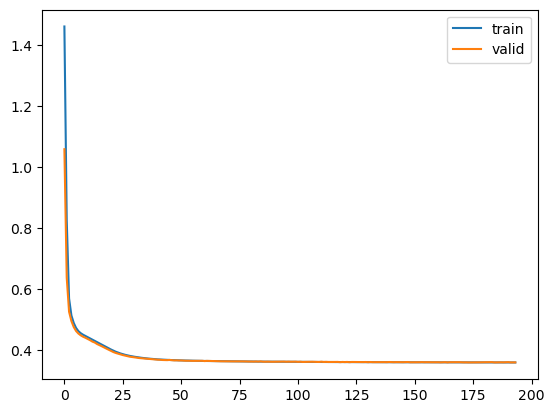

In [36]:
from matplotlib import pyplot
pyplot.plot(train_loss, label='train')
pyplot.plot(val_loss, label='valid')
pyplot.legend()
pyplot.show()

In [37]:
model = DNN_Regression(input_dim=train_x.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
print(preds)

100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 1340.28it/s]

[[ 11.522877    -0.45891166  -5.000174   ... -19.079918   -17.327497
  -19.717089  ]
 [  3.4668097    2.0202355   -1.556679   ...  -7.9663124   -9.2513485
  -11.3541355 ]
 [ 10.767844     0.67689764  -5.2020745  ... -19.572205   -18.144556
  -20.792395  ]
 ...
 [  4.1254325    2.522038    -2.2381775  ... -10.006866   -11.075038
  -13.432025  ]
 [ 10.8720045   -0.13093165  -4.867985   ... -18.404003   -16.822306
  -19.18851   ]
 [ 10.521076    -0.34731168  -5.1300683  ... -17.712158   -15.624329
  -17.521753  ]]


In [38]:
prediction = []
for i in preds:
    if i[0] > i[1]:
        prediction.append(0)
    else:
        prediction.append(1)

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_train_x = pca.fit_transform(train_x)

pca_test_x = pca.transform(test_x)

df = pd.DataFrame(pca_test_x)
df['y'] = prediction
df['groundTrue'] = test_y
df

,0,y,groundTrue
0,2.520483,0,0
1,2.635523,0,0
2,5.039812,0,0
3,7.565258,0,0
4,2.512272,0,0
...,...,...,...
31200,-7.453044,0,0
31201,-7.416707,0,1
31202,5.094402,0,0
31203,2.533309,0,0


/tmp/ipykernel_25464/920653628.py:5: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(


<AxesSubplot:xlabel='0', ylabel='y'>

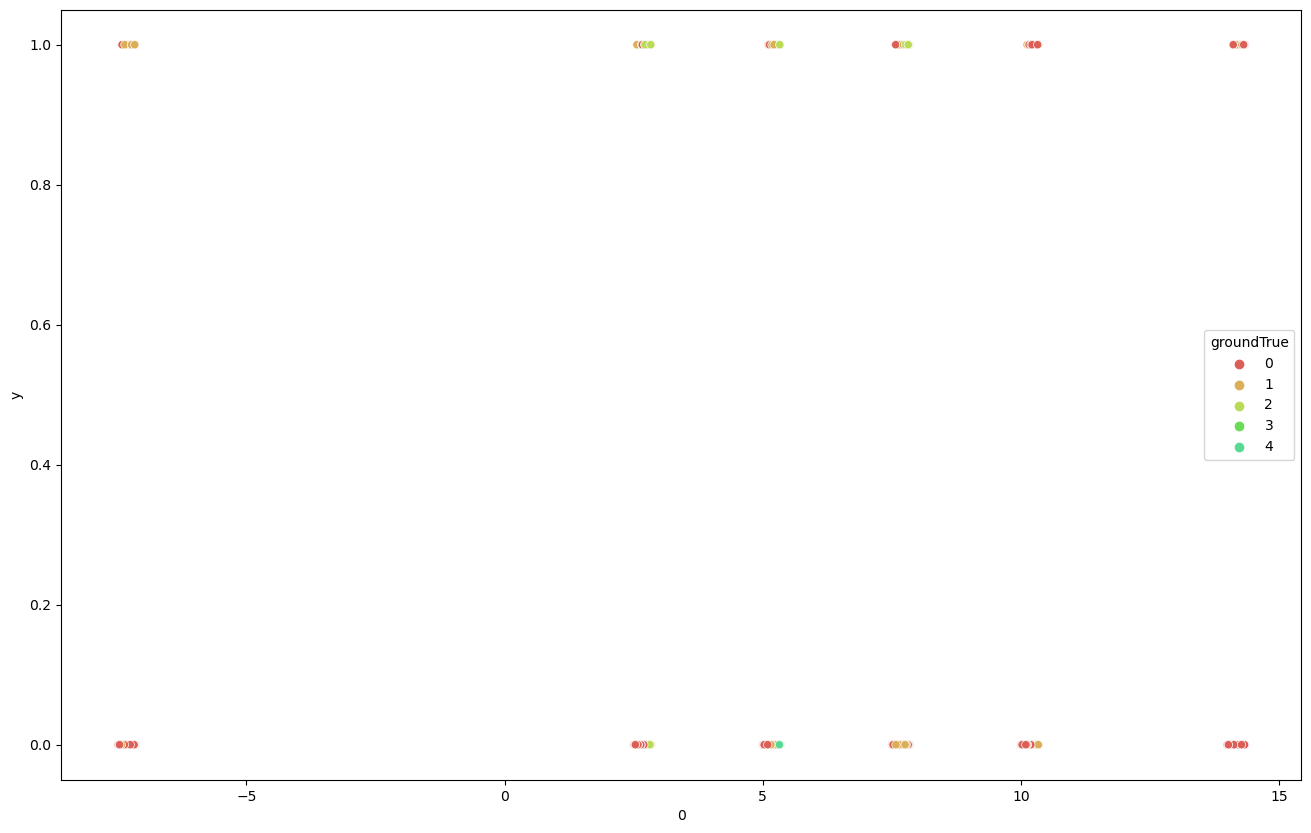

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y='y',
    hue="groundTrue",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=1
)

In [41]:
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92     26308
           1       0.45      0.09      0.16      4282
           2       0.00      0.00      0.00       525
           3       0.00      0.00      0.00        79
           4       0.00      0.00      0.00        11

    accuracy                           0.85     31205
   macro avg       0.26      0.22      0.21     31205
weighted avg       0.79      0.85      0.80     31205



/home/sea120424/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sea120424/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sea120424/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [62]:
from sklearn.metrics import det_curve
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from matplotlib import pyplot as plt
import matplotlib
import bob.measure

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def DETCurve(fps,fns):
    """
    Given false positive and false negative rates, produce a DET Curve.
    The false positive rate is assumed to be increasing while the false
    negative rate is assumed to be decreasing.
    """
    axis_min = min(fps[0],fns[-1])
    fig, ax = plt.subplots()
    plt.plot(fps,fns)
    plt.yscale('log')
    plt.xscale('log')
    ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50]
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    plt.axis([0.001,50,0.001,50])

def generate_det_curve(p_scores, n_scores):
        #matplotlib.use('TkAgg')

        plt.switch_backend('agg')
        bob.measure.plot.det(n_scores, p_scores, 1000, color = (0,0,0), linestyle = '-')
        bob.measure.plot.det_axis([0.01, 99, 0.01, 99])
        threshold = bob.measure.eer_threshold(n_scores, p_scores)
        far, frr = bob.measure.farfrr(n_scores, p_scores, threshold)
        
        print(far, frr)
        x = range(99)
        ax = plt.gca()
        #ax.plot(x)
        ax.set_aspect('equal', adjustable='box')
        plt.plot([100, -10], [100, -10], linestyle='--', label=f"Equal error rate = {max(far, frr)* 100}%")
        print("##########")
        print(max(far, frr) * 100)
        print("##########")
        plt.xlabel('FAR (%)')
        plt.ylabel('FRR (%)')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend(loc="lower right")
        
        plt.savefig('fig/det.png')
        plt.cla()
        plt.clf()
        
        return max(far, frr) * 100


In [40]:
prob_prediction = []
scores = []
for i in preds:
    scores.append(softmax(i)[1])
    prob_prediction.append(i[1])
    
scores = np.array(scores)
fpr, fnr, thresholds = det_curve(test_y, prob_prediction)
print(scores)

[0.00106942 0.00082625 0.00063377 ... 0.00088757 0.00085617 0.00121412]


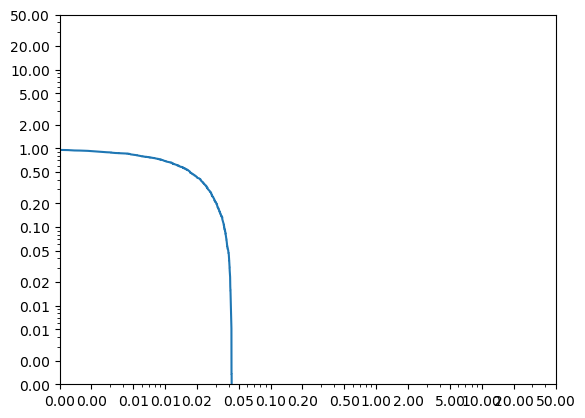

In [33]:
DETCurve(fpr, fnr)

In [56]:
labels = test_y

p_scores, n_scores = scores[np.where(labels == True)].astype(np.double), scores[np.where(labels == False)[0]].astype(np.double)

In [63]:
print(p_scores, n_scores)

generate_det_curve(p_scores, n_scores)

[0.98094857 0.95037997 0.97500229 ... 0.95823359 0.94426686 0.97156   ] [0.00106942 0.00082625 0.00063377 ... 0.00088757 0.00085617 0.00121412]
0.04001455074572572 0.040107671601615075
##########
4.010767160161508
##########


4.010767160161508

KeyboardInterrupt: 